# COVID-19 Infection curve analysis                                                                      
## Naoaki ONO nono@is.nasit.jp   

CoViD-19 infection curve (in Japan, from Jan. 15, 2020) analysis using R.

The numbers of infected and tested by PCR have been gathered from the website of Ministry of Health, Labour and Welfare, Japan

Sources and data are available on GitHub.
https://github.com/naono-git/covid19

Open using [nbviewer service](https://nbviewer.jupyter.org/github/naono-git/covid19/tree/master/covid19.ipynb)


Prepare the library

In [584]:
library(date)
# library(smooth)
source("src/plotUtil.R")

Load the population table.

This table is updated everyday (manually X-<) according to the web site of [MHLW](https://www.mhlw.go.jp/stf/houdou/index.html)

In [652]:
# covid <- read.delim("data/covid19.txt", header=TRUE, sep="\t")
covid <- read.delim("data/covid19.total.txt", header=TRUE, sep="\t")
nd <- nrow(covid)
stamp <- paste(c(covid[nd,1],sprintf("%02d",covid[nd,2]),sprintf("%02d",covid[nd,3])),collapse="")
stamp

[1] "20200427"

In [653]:
ddd <- mdy.date(month=covid$mm, day=covid$dd, year=covid$yy)
d0  <- ddd[1]
dd1 <- ddd-d0 ## relative date starting from 2020/01/15                                                   
dd1[1] <- 7   ## initial offset (aribtrary chosen) 

In [654]:
## dates to plot ticks                                                                                    
mdlabel <- rbind(c(1,15),
                 c(2, 1),
                 c(2,15),
                 c(3, 1),
                 c(3,15),
                 c(4, 1),
                 c(4,15),
                 c(5, 1),
                 c(5,15),
                 c(6, 1),
                 c(6,15),
                 c(7, 1),
                 c(7,15),
                 c(8, 1),
                 c(8,15),
                 c(9, 1),
                 c(9,15),
                 c(10, 1),
                 c(10,15),
                 c(11, 1),
                 c(11,15),
                 c(12, 1),
                 c(12,15)
                )
ddlabel <- apply(mdlabel,1,function(xx){
    mdy.date(xx[1],xx[2],2020)
})
## label to plot ticks                                                                                    
ticklabel <- apply(mdlabel,1,paste,collapse="/")

In [655]:
logd <- log(dd1)        ## log day
logi <- log(covid$i)    ## log number of infected                                                               
logp <- log(covid$PCR)  ## log number of PCR

In [656]:
daydiff <- function(xx){
    return(xx - c(0,xx[-length(xx)]))
}
pred_pow <- function(xx,cc,ll){
    return(xx^ll*exp(cc))
}
pred_exp <- function(xx,cc,ll){
    return(cc*exp(ll*xx))
}

Generally, there remains possibility that the growth is not close to exponential. We'd better to compare several models

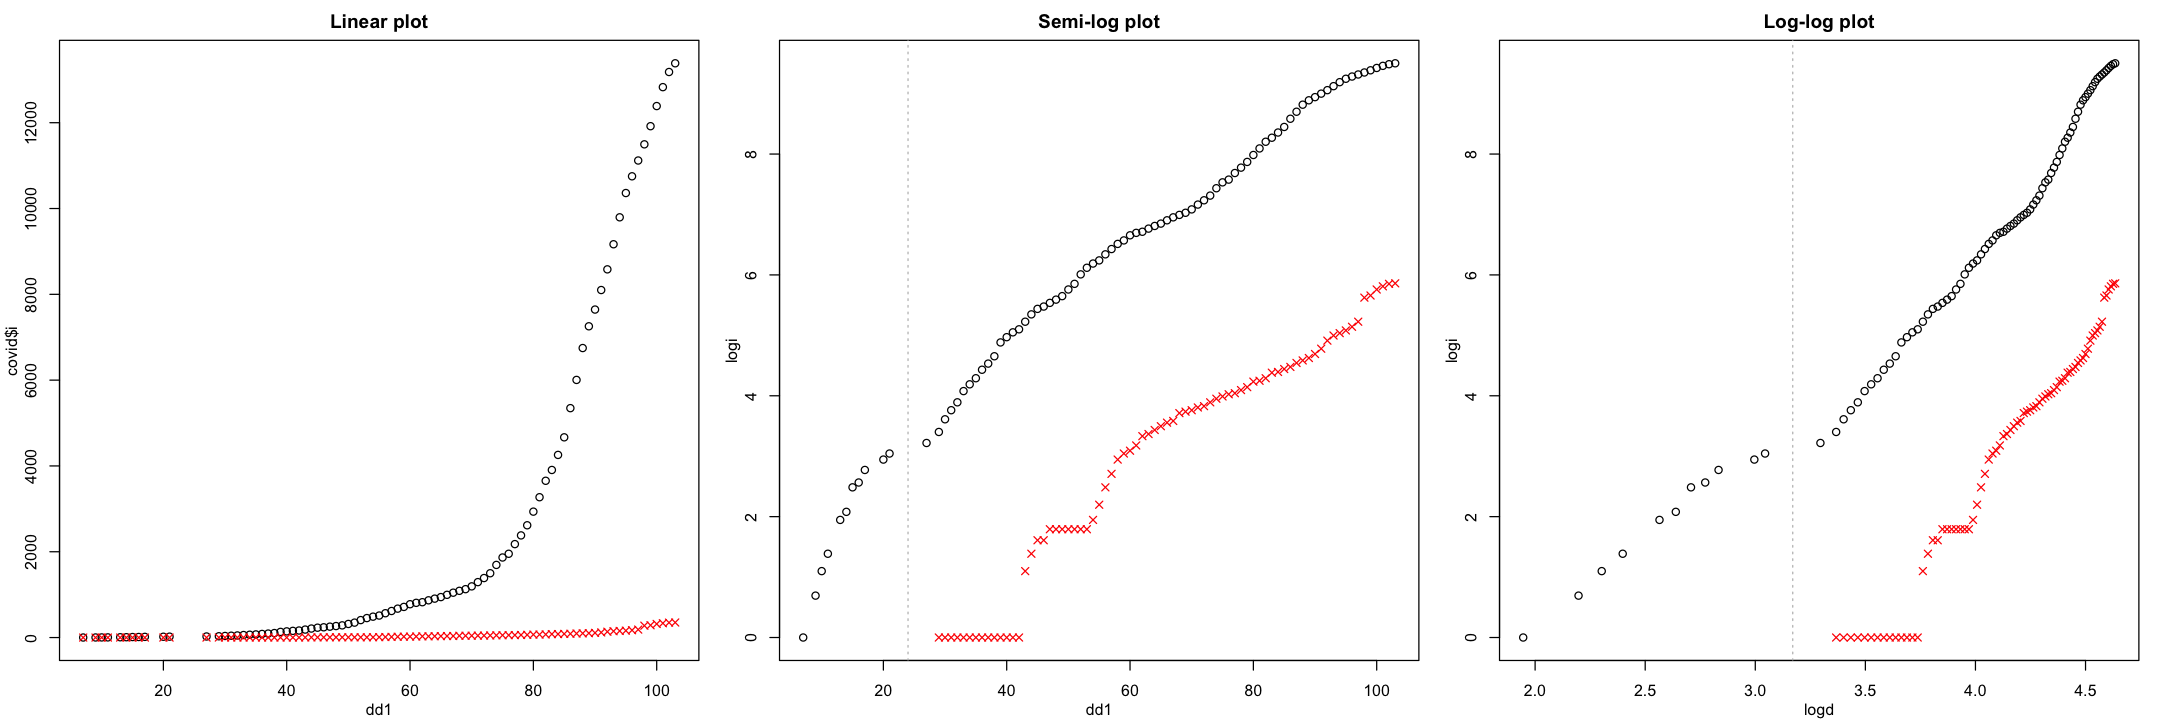

In [657]:
options(repr.plot.width=18, repr.plot.height=6)
par(mfcol=c(1,3))
par.margin("smart")

plot(dd1, covid$i, main="Linear plot")
points(dd1, covid$d, pch=4, col=2)

plot(dd1, logi, main="Semi-log plot")
points(dd1, log(covid$d), pch=4, col=2)

abline(v=mean(dd1[11:12]), lty=3, col=8)

plot(logd, logi, main="Log-log plot")
points(logd, log(covid$d), pch=4, col=2)
abline(v=mean(logd[11:12]), lty=3, col=8)


## ... Do you think which one looks like "linearly"?

In [658]:
## Fitting by power. 1, fit for the earlier stage                                                   
model_pow_0 <- lm(logi~logd)
model_pow_0

model_pow_1 <- lm(logi[1:11]~logd[1:11])
model_pow_1

## Fitting by power. 2, fit for the latter stage                                                   
model_pow_2 <- lm(logi[12:nd]~logd[12:nd])
model_pow_2


Call:
lm(formula = logi ~ logd)

Coefficients:
(Intercept)         logd  
     -8.184        3.674  



Call:
lm(formula = logi[1:11] ~ logd[1:11])

Coefficients:
(Intercept)   logd[1:11]  
     -5.562        2.894  



Call:
lm(formula = logi[12:nd] ~ logd[12:nd])

Coefficients:
(Intercept)  logd[12:nd]  
    -12.754        4.763  


In [659]:
## We focus on the latter growth (D > Feb. 11th)
model_exp_2 <- lm(logi[12:nd]~dd1[12:nd])
model_exp_2
confint(model_exp_2)
exp(c(0.07938246,0.08346356))
cc_exp_2 <- exp(model_exp_2$coefficients[1])
ll_exp_2 <- model_exp_2$coefficients[2]


Call:
lm(formula = logi[12:nd] ~ dd1[12:nd])

Coefficients:
(Intercept)   dd1[12:nd]  
    1.63303      0.07984  


,2.5 %,97.5 %
(Intercept),1.49877856,1.76728953
dd1[12:nd],0.07790047,0.08178795


[1] 1.082618 1.087046

In [660]:
model_toll_2 <- lm(log(covid$d[60:nd])~dd1[60:nd])
model_toll_2
cc_toll_2 <- exp(model_toll_2$coefficients[1])
ll_toll_2 <- model_toll_2$coefficients[2]


Call:
lm(formula = log(covid$d[60:nd]) ~ dd1[60:nd])

Coefficients:
(Intercept)   dd1[60:nd]  
    -1.5878       0.0716  


In [661]:
mean(covid$re[(nd-24):nd-1] / covid$i[(nd-24):nd-1])

[1] 0.1516714

COVID19_infection_curve_semilog_20200427.jpg 


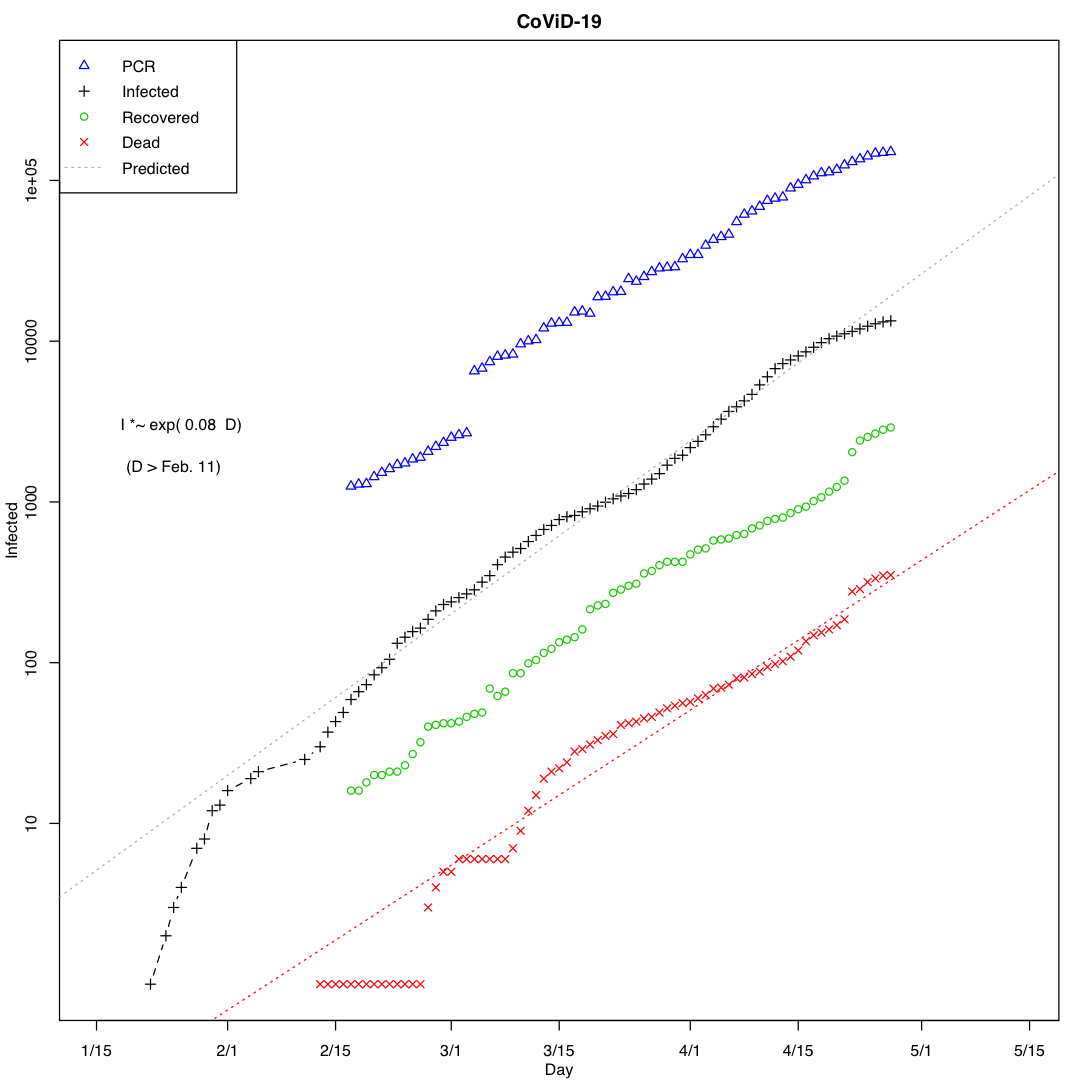

In [662]:
options(repr.plot.width=9, repr.plot.height=9)

file_plot1 <- paste("COVID19_infection_curve_semilog",stamp,sep="_")

plotFigure(function(){
    plot(dd1, logi, axes=FALSE, frame=TRUE, type="b", lty=2, pch=3,
         xlim=c(0,120),ylim=c(0,13), xlab="Day", ylab="Infected", main="CoViD-19")
    points(dd1, logp, pch=2, col=4)
    points(dd1, log(covid$d), pch=4, col=2)
    points(dd1, log(covid$re), pch=1, col=3)
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))

    legend("topleft",lty=c(0,0,0,0,3),pch=c(2,3,1,4,NA),col=c(4,1,3,2,8),legend=c("PCR","Infected","Recovered","Dead","Predicted"))
    # text(10,8,TeX(paste("$I \\propto exp(",round(ll_exp_2,3)," D)$")))
    text(11,8,paste("I *~ exp(",round(ll_exp_2,3)," D)"))
    text(10,7.4,"(D > Feb. 11)")

    abline(model_exp_2, lty=3, col=8)
    abline(model_toll_2, lty=3, col=2)
},rr=1.5,dir="fig",file=file_plot1,dev=c("x11","jpg"))

## Simulation

### SIR model
In general, the dynamics of infection is described by the "SIR" model.
$$
\frac{dS}{dt} = -\beta IS \\
\frac{dI}{dt} = \beta IS - \gamma I \\
\frac{dR}{dt} = \gamma I,
$$
where S denotes the population ratio of susceptible, I denotes infected, R denotes recoverd, respectively, and $\beta$ and $\gamma$ are the coefficient of infection and recovery.

### SEIR model
Here we assume a modified SEIR model. $S$: susceptible, $E$: exposed and infected but not show symptoms yet, $I$: infected and separeted in a hospital, $R_E$, $R_I$: recovered from $E$ or $I$, respectively, and no longer susceptible.

$$
\frac{dS}{dt} = -\alpha E S /N \\
\frac{dE}{dt} = \alpha E S/N - \beta E - \gamma E\\
\frac{dI}{dt} = \beta E - \gamma I \\
\frac{dR_E}{dt} = \gamma E, \\
\frac{dR_I}{dt} = \gamma I,
$$
where $N$ is the population of the country (Nara), $\alpha$ is an infection rate, $\beta$ is an onset rate, $\gamma$ is a recover rate.

Where the growth looks linear in the semi-log prot, we can expect the simplest growth dynamics,

$$
\frac{dE}{dt} = (\alpha -\beta - \gamma) E = \lambda E\\
E = E_0 \exp(\lambda t) \\
\log(E) = C_0 + \lambda t
$$

And, the other variables can be approximated by the exponential, too,
$$
I = I_0 \exp(\lambda t) = \frac{\beta}{1+\gamma} E_0 \exp(\lambda t) \\
R_E = \gamma E_0 \exp(\lambda t) \\
R_I = \gamma I_0 \exp(\lambda t) \\
$$

### Recovery delay

According to Nara Prefecture hosptial, the average recovery period is about 12 days.

We tentatively tested the another model that considers $d_r = 12$ days delay for recovery, 

$$
\frac{dR_E}{dt}(t) = \gamma E(t-d_r), \\
\frac{dR_I}{dt}(t) = \gamma I(t-d_r),
$$

### Monte-Carlo Simulation

In [596]:
simSEIR_delay <- function(nd, par){
    sst <- integer(nd)
    eet <- integer(nd)
    iit <- integer(nd)
    ret <- integer(nd)
    rit <- integer(nd)
    dst <- integer(nd)
    det <- integer(nd)
    dit <- integer(nd)
    dret <- integer(nd)
    drit <- integer(nd)

    alpha <- par[["alpha"]]
    beta  <- par[["beta"]]
    gamma <- par[["gamma"]]
    nn <- par[["nn"]]

    ss <- nn
    ee <- par[["e0"]]
    ii <- par[["i0"]]
    re <- par[["re0"]]
    ri <- par[["ri0"]]
    dd <- 1
    sst[dd] <- ss
    eet[dd] <- ee
    dit[dd] <- 1
    iit[dd] <- ii
    ret[dd] <- re
    rit[dd] <- ri
    for(dd  in 2:nd){
        if(dd > 7){
            ee6 <- eet[dd-6]
            if(ee6 < ee){
                ee6 <- ee
            }
        } else {
            ee6 <- ee
        }
        if(dd > 13){
            ee12 <- eet[dd-12]
            ii12 <- iit[dd-12]
        } else {
            ee12 <- ee
            if(ee12 < ee){
                ee12 <- ee
            }
            ii12 <- ii
            if(ii12 < ii){
                ii12 <- ii
            }
        }
        if(ss <= 0){
            t1 <- 0
        } else {
            t1 <- rpois(1, ss/nn*ee*alpha)            
        }
        t2 <- rbinom(1, ee6, beta)
        t3 <- rbinom(1, ee12, gamma)
        t4 <- rbinom(1, ii12, gamma)
        ss <- ss - t1
        ee <- ee + t1 - t2 - t3
        if(ee <= 0){
            ss <- ss + (ee-1)
            ee <- 1
        }
        ii <- ii + t2 - t4
        if(ii <= 0){
            ss <- ss + (ii-1)
            ii <- 1
        }
        re <- re + t3
        ri <- ri + t4
        sst[dd] <- ss
        eet[dd] <- ee
        iit[dd] <- ii
        ret[dd] <- re
        rit[dd] <- ri
        dst[dd] <- -t1
        det[dd] <- +t1-t2-t3
        dit[dd] <-    +t2   -t4
        dret[dd] <-      +t3
        drit[dd] <-         +t4
    }    
    return(cbind(sst=sst,eet=eet,iit=iit,ret=ret,rit=rit,dst=dst,det=det,dit=dit,dret=dret,drit=drit))
}

In [597]:
n0_total <- 126e+6
covid[17,]
i0_total <- covid$i[17]-covid$re[17]
r0_total <- covid$r[17]+covid$d[17]

e0_total <- i0_total*3

alpha_tmp <- 0.33
beta_tmp  <- 0.18
gamma_tmp <- 1/20
par_tmp <- list(alpha=alpha_tmp, beta=beta_tmp, gamma=gamma_tmp, nn=n0_total, e0=e0_total, i0=i0_total, re0=r0_total, ri0=r0_total)

,yy,mm,dd,i,d,PCR,re
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
17,2020,2,17,59,1,1251,16


In [598]:

# sim_tmp <- simSEIR(365, par=par_tmp)
sim_tmp <- simSEIR_delay(365, par=par_tmp)

By minimizing mean squared loss between simulated and observed numbers, we optimize the parameters.

In [599]:
loss <- function(tmp){
    iii <- which(dd1 >= dd1[17] & dd1 <= dd1[nd])
    mean((log(covid$i[iii]-covid$re[iii]) - log(tmp[1:length(iii),"iit"]))^2) + mean((log(covid$re[iii]) - log(tmp[1:length(iii),"rit"]))^2)
}
lossn <- function(lpar, nl){
    alpha <- exp(lpar[["lalpha"]])
    beta  <- exp(lpar[["lbeta"]])
    gamma <- exp(lpar[["lgamma"]])

    par_tmp <- list(alpha=alpha, beta=beta, gamma=gamma, nn=n0_total, e0=e0_total, i0=i0_total, re0=r0_total, ri0=r0_total)
    lll <- sapply(1:nl,function(par){
        sim_tmp <- simSEIR_delay(365, par=par_tmp)
        loss(sim_tmp)
    })
    return(mean(lll))
}


In [600]:
alpha_tmp <- 0.31
beta_tmp  <- 0.16
gamma_tmp <- 1/12
e0_total <- 100
par_tmp <- list(alpha=alpha_tmp, beta=beta_tmp, gamma=gamma_tmp, nn=n0_total, e0=e0_total, i0=i0_total, re0=r0_total, ri0=r0_total)

sim_tmp <- simSEIR_delay(365, par=par_tmp)

loss(sim_tmp)

lossn(lpar=list(lalpha=log(alpha_tmp), lbeta=log(beta_tmp), lgamma=log(gamma_tmp)), nl=300)

[1] 5.741585

[1] 4.341623

In [606]:
optim_tmp <- optim(c(lalpha=log(alpha_tmp), lbeta=log(beta_tmp), lgamma=log(gamma_tmp)), function(lpar){lossn(lpar, 100)})


The optimized parameters are as follows.

Alpha: infection rate, Beta: detection rate, Gamma: recovery rate.

In [607]:
alpha_all <- exp(optim_tmp$par[[1]])
beta_all  <- exp(optim_tmp$par[[2]])
gamma_all <- exp(optim_tmp$par[[3]])
c(aplha = alpha_all, beta=beta_all, gamma=gamma_all)

aplha       beta      gamma 
0.30925540 0.18929976 0.08011005

In [608]:
alpha_all / (beta_all+gamma_all)

[1] 1.1479

## Simulation of Nara population

In [681]:
pref47.infected <- read.delim("data/pref47.infected.txt", header=TRUE, sep="\t")
pref47.recovered <- read.delim("data/pref47.recovered.txt", header=TRUE, sep="\t")
nd2 <- nrow(pref47.infected)
pref47.infected[nd2 ,]
## Note that the date in the pref* table are not the date when they published but the date when they are accumulated.
## We prefer to use the date of publised, so add one day to the date.p47

date.p47 <- mdy.date(month=pref47.infected$Month, day=pref47.infected$Day, year=2020)+1  
d0.p47  <- date.p47[1]
dd2 <- date.p47-d0.p47 ## relative date starting from 2020/01/15                                                   

n0_nara <- 1348e+3
e0_nara <- pref47.infected[1,"Nara"]
i0_nara <- pref47.infected[1,"Nara"]
re0_nara <- pref47.recovered[1,"Nara"]
ri0_nara <- pref47.recovered[1,"Nara"]

,Month,Day,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,...,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa,Total
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
28,4,26,615,22,0,85,16,66,69,161,...,73,606,36,16,45,60,17,10,133,13232


In [665]:
set.seed(1)
par_tmp <- list(alpha=alpha_all, beta=beta_all, gamma=gamma_all, nn=n0_nara, e0=e0_nara, i0=i0_nara, re0=re0_nara, ri0=ri0_nara)
sim_tmp <- simSEIR_delay(365, par=par_tmp)

We simulate variation assuming some smaller infection rates and some larger detection rates.

sim_var_2.jpg 


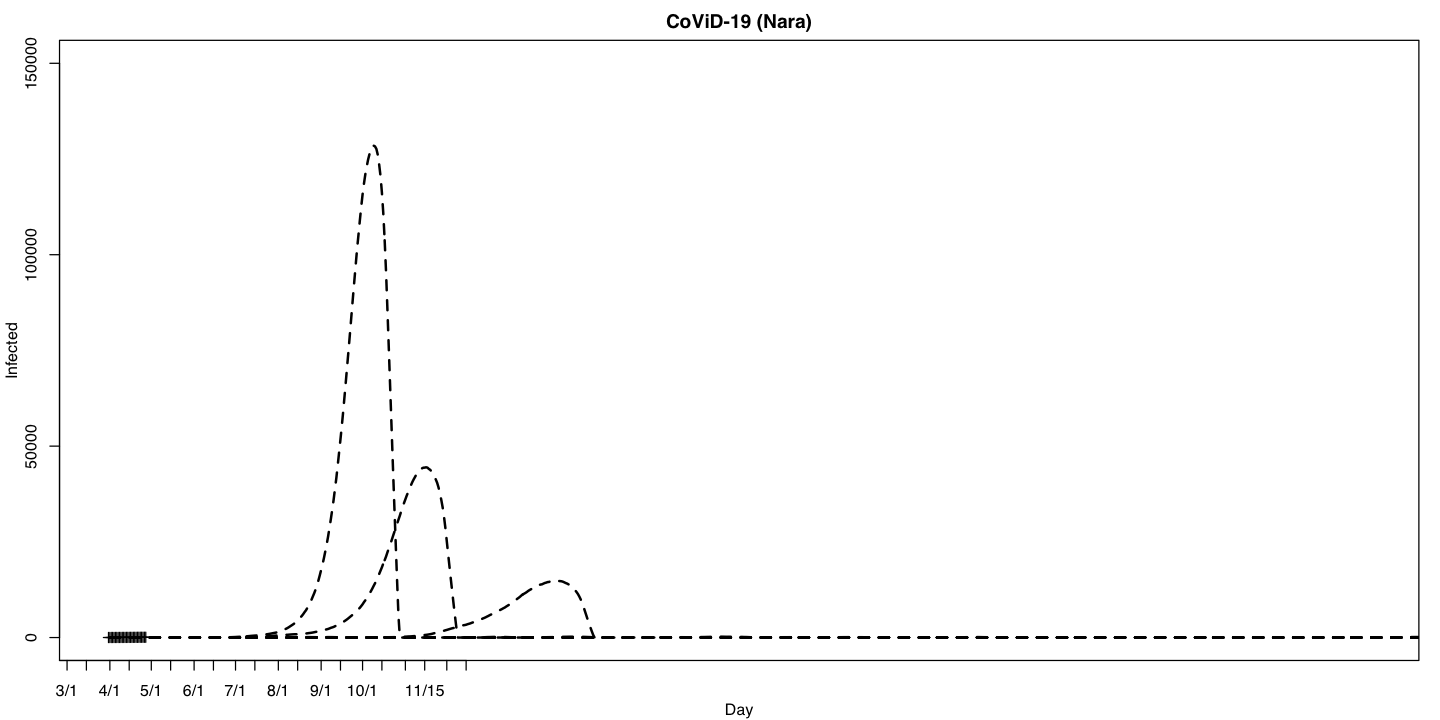

In [687]:
# alpha
# 0.366736905989128
# beta
# 0.277270163138632
# gamma
# 0.0187658947978138

par_ratio <- rbind(
    c(1.00, 1.00),
#    c(0.95, 1.00),
#    c(1.00, 1.05),
#    c(0.95, 1.05),
    c(0.90, 1.00),
    c(1.00, 1.10),
    c(0.90, 1.10),
#    c(0.85, 1.00),
#    c(0.85, 1.10),
#    c(1.00, 1.15),
#    c(0.95, 1.15),
#    c(0.90, 1.15),
    c(0.85, 1.15),
    c(0.80, 1.00),
    c(0.75, 1.00),
    c(0.70, 1.00),
    c(0.60, 1.00),
    c(0.50, 1.00)
)
set.seed(6)
pred_peak <- NULL
pred_curve <- list()
for(aa in 1:nrow(par_ratio)){
    ra <- par_ratio[aa,1]
    rb <- par_ratio[aa,2]
    par_tmp <- list(alpha=alpha_all*ra, beta=beta_all*rb, gamma=gamma_all, nn=n0_nara, e0=as.integer(e0_total/n0_total*n0_nara), i0=as.integer(i0_total/n0_total*n0_nara), re0=as.integer(r0_total/n0_total*n0_nara), ri0=as.integer(r0_total/n0_total*n0_nara))
    sim_tmp <- simSEIR_delay(365*4, par=par_tmp)
    pred_curve[[aa]] <- sim_tmp
    pred_peak <- rbind(pred_peak, c(alpha=ra, beta=rb, max=max(sim_tmp[,"iit"]), tot=sim_tmp[,"rit"][[730]]+sim_tmp[,"ret"][[730]], peak=which.max(sim_tmp[,"iit"])))
}

options(repr.plot.width=12, repr.plot.height=6)

plotFigure(function(){
    plot(dd2, pref47.infected[,"Nara"], axes=FALSE, frame=TRUE, type="b", lty=2, pch=3, xlim=c(1,365*2.5), ylim=c(10,150000),
         xlab="Day", ylab="Infected", main="CoViD-19 (Nara)")
    for(aa in 1:nrow(par_ratio)){
        points(1:(365*4),(pred_curve[[aa]][,"iit"]), col=1,type="l",lty=2, lwd=2)        
    }
    axis(1,at=ddlabel-d0.p47,labels=ticklabel)
    axis(2)
},rx=1.5/270*365*2.5,ry=1.5,dir="fig",file="sim_var_2",dev=c("x11","jpg"))


In [667]:
cbind(pred_peak[,-5], peak=paste(d0.p47+pred_peak[,5]))

alpha,beta,max,tot,peak
1,1,128481,475848,9Oct2020
0.9,1,14929,105351,18Feb2021
1,1.1,44470,222902,16Nov2020
0.9,1.1,143,1376,22Oct2023
0.85,1.15,165,1335,5Jan2021
0.8,1,217,1872,1Mar2021
0.75,1,71,855,8May2023
0.7,1,80,750,13May2023
0.6,1,28,452,25May2023
0.5,1,15,375,28Apr2022


In [688]:
round((pred_peak[,3] / n0_nara)*100,1)

[1] 9.5 1.1 3.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0

## Short term prediction (exponential regression)

First, look the curves of the infected population in 4 prefectures in Kinki area.

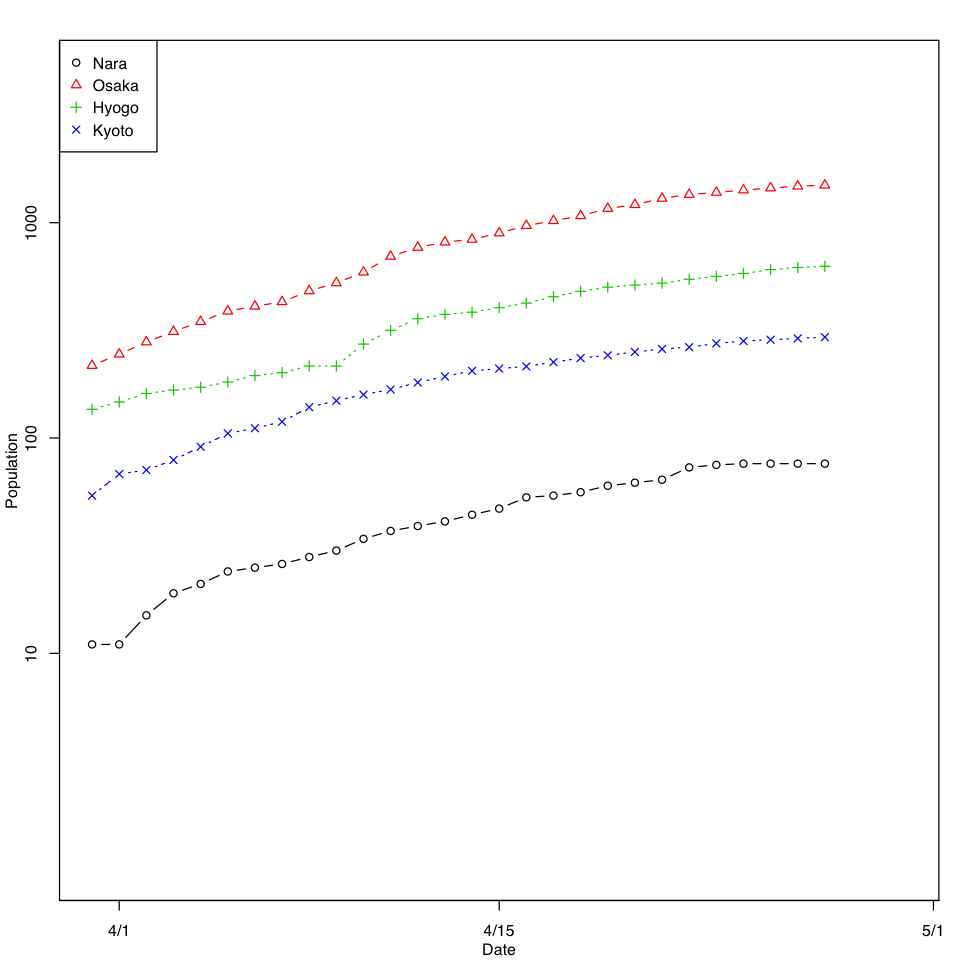

In [669]:
options(repr.plot.width=8, repr.plot.height=8)

pref_kinki4 <- c("Nara","Osaka","Hyogo","Kyoto")
plotFigure(function(){
    matplot(dd2, log(pref47.infected[,pref_kinki4]),type="b",pch=1:4, col=1:4, xlim=c(0,30), ylim=log(c(1,5000)),axes=FALSE, frame=TRUE, ylab="Population", xlab="Date")
    axis(1,at=ddlabel-d0.p47,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))
    legend("topleft",pch=1:4, col=1:4, legend=pref_kinki4)
},dir="fig",file=paste("kinki4_",stamp,sep=""),dev=c("x11"))

We can fit their growth by exponential regression (linear regression in semi-log plot).

In [682]:
## We focus on the latter growth (D > Feb. 11th)
lm_all <- lm(logi[(nd-18):nd]~dd1[(nd-18):nd])
lm_all
confint(lm_all)

ll_all <- lm_all$coefficients[2]
ll_all
cc_nara <- log(pref47.infected[nd2, "Nara"]) - ll_all*dd2[nd2]

lm_kinki4 <- lapply(1:4,function(aa){
    pref <- pref_kinki4[aa]
    xxx_tmp <- dd2[(nd2-13):nd2]
    yyy_tmp <- log(pref47.infected[(nd2-13):nd2,pref])
    lm_tmp <- lm(yyy_tmp~xxx_tmp)
    return(lm_tmp)
})
names(lm_kinki4) <- pref_kinki4
lm_kinki4[["Nara"]]$coefficients
# cc_nara <- lm_kinki4[["Nara"]]$coefficients[1]
ll_nara <- lm_kinki4[["Nara"]]$coefficients[2]


Call:
lm(formula = logi[(nd - 18):nd] ~ dd1[(nd - 18):nd])

Coefficients:
      (Intercept)  dd1[(nd - 18):nd]  
          3.95471            0.05491  


,2.5 %,97.5 %
(Intercept),3.35569845,4.55371702
dd1[(nd - 18):nd],0.04854586,0.06126916


dd1[(nd - 18):nd] 
       0.05490751

(Intercept)     xxx_tmp 
 3.23188442  0.04419452

It implies about 6% growth par day.

In [683]:
exp(ll_all)
log(2)/ll_all

exp(ll_nara)
log(2)/ll_nara


dd1[(nd - 18):nd] 
         1.056443

dd1[(nd - 18):nd] 
         12.62391

xxx_tmp 
1.045186

xxx_tmp 
15.68401

As you see the regression lines would predict the growth in the near future.

kinki4_20200427.jpg 


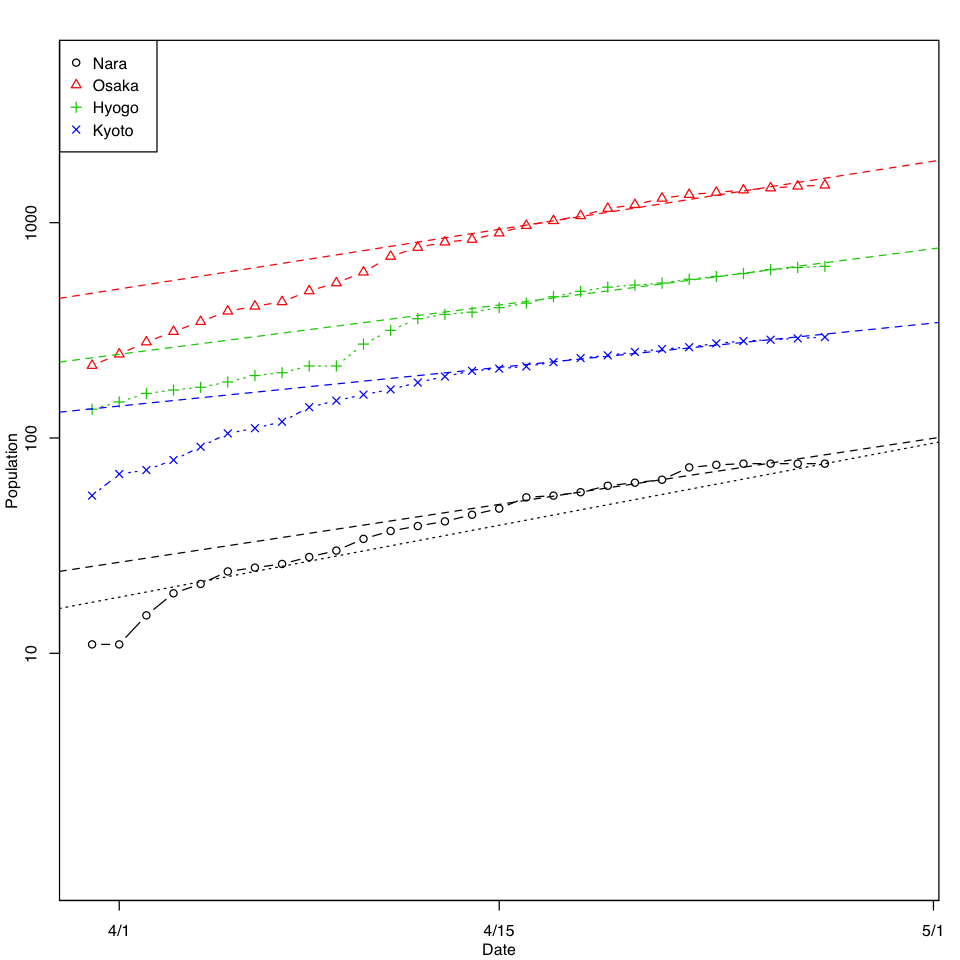

In [684]:
pref_kinki4 <- c("Nara","Osaka","Hyogo","Kyoto")
plotFigure(function(){
    matplot(dd2, log(pref47.infected[,pref_kinki4]),type="b",pch=1:4, col=1:4, xlim=c(0,30), ylim=log(c(1,5000)),axes=FALSE, frame=TRUE, ylab="Population", xlab="Date")
    axis(1,at=ddlabel-d0.p47,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))
    for(aa in 1:4){
        abline(lm_kinki4[[aa]], lty=2, col=aa)
    }
    abline(cc_nara,ll_all, lty=3, col=1)
    legend("topleft",pch=1:4, col=1:4, legend=pref_kinki4)
},rr=1.5, dir="fig",file=paste("kinki4_",stamp,sep=""),dev=c("x11","jpg"))

In [691]:
date_pred <- rbind(
#    c(4,21),
#    c(5, 1),
    c(5, 7),
    c(5,15),
    c(5,21),
    c(5,28),
    c(5,29),
    c(5,30),
    c(5,31),
    c(6, 7),
    c(6, 8),
    c(6, 18),
    c(6, 19),
    c(6, 20))
colnames(date_pred) <- c("Month","Day")
ddd_pred <- apply(date_pred,1,function(xx){
    mdy.date(xx[1],xx[2],2020) - d0.p47
})

predict_kinki <- function(coef, dd){
    bb <- coef[1]
    aa <- coef[2]
    return(round(exp(aa*dd+bb)))
}
# pref47.infected[,pid["奈良県"]+2]


Since the infection rate in all Japan is slightly higher than that in Nara, we evaluated using both two rates, Nara and all Japan.

In [692]:
predicted2 <- predict_kinki(c(cc_nara,ll_all),ddd_pred)
recovered2 <- predict_kinki(c(cc_nara,ll_all),ddd_pred-12)
cbind(date_pred, Predicted=predicted2, Recovered=recovered2, Bed=predicted2-recovered2)

predicted1 <- predict_kinki(lm_kinki4[["Nara"]]$coefficients,ddd_pred)
recovered1 <- predict_kinki(lm_kinki4[["Nara"]]$coefficients,ddd_pred-12)
cbind(date_pred, Predicted=predicted1, Recovered=recovered1, Bed=predicted1-recovered1)

Month,Day,Predicted,Recovered,Bed
5,7,132,68,64
5,15,204,106,98
5,21,284,147,137
5,28,417,216,201
5,29,440,228,212
5,30,465,241,224
5,31,492,254,238
6,7,722,374,348
6,8,763,395,368
6,18,1321,683,638


Month,Day,Predicted,Recovered,Bed
5,7,130,76,54
5,15,185,109,76
5,21,241,142,99
5,28,329,193,136
5,29,344,202,142
5,30,359,211,148
5,31,375,221,154
6,7,511,301,210
6,8,534,314,220
6,18,832,489,343


In [695]:
log(2)/8.66

[1] 0.08004009